In [32]:
from IPython.display import clear_output # clear_output(wait=True)
import json
import math
import pickle
import random
from statistics import mean
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from ast import literal_eval
import gensim.downloader as api
from sklearn.metrics import f1_score, accuracy_score
import tensorflow as tf
import tensorflow_addons as tfa

#### Cell to prevent the session on the collab from being disconnected - irrelevant

In [33]:
sleep_minutes = 0  # 120

for i in range(sleep_minutes):
    clear_output(wait=True)
    print(f'{sleep_minutes-i}min left')
    time.sleep(60)

clear_output(wait=True)
print(f'done')

done


Setting seed value

In [34]:
seed_value = 1234

tf.random.set_seed(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

#### get_word_index() -> get dict() <index: 'word'> from reuters dataset

#### load_data()-> load reuters dataset

#### prepare_data() -> prepare data for processing (returns data from 10 most frequent classes)

In [35]:
def get_word_index():
    word_index = tf.keras.datasets.reuters.get_word_index()
    word_id = dict([(value, key) for key, value in word_index.items()])
    
    return word_id


def load_data(num_words=2000, seed_value=seed_value):
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.reuters.load_data(path="reuters.npz",
                                                                               num_words=num_words,
                                                                               test_split=0.2,
                                                                               seed=seed_value)
    
    return (x_train, y_train), (x_test, y_test)


def prepare_data(x_train, y_train, 
                 x_test, y_test, 
                 num_classes=10, 
                 verbose=True):
    x_arr = np.concatenate((x_train, x_test))
    y_arr = np.concatenate((y_train, y_test))

    dataset_df = pd.DataFrame(columns=['x', 'y'])
    dataset_df['x'] = x_arr
    dataset_df['y'] = y_arr

    most_frequent_classes = dataset_df['y'].value_counts()[:num_classes].index.tolist()

    dataset_df = dataset_df[dataset_df['y'].isin(most_frequent_classes)].reset_index(drop=True)
    map_dict = dict(zip(most_frequent_classes, list(range(num_classes))))
    dataset_df['y'] = dataset_df['y'].map(map_dict)

    if verbose:
        print(f'Dataset: {dataset_df.shape}')
        print(f'Max lenght of x: {max(len(x_item) for x_item in x_arr)}')
        print('CLS   CNT')
        print(dataset_df['y'].value_counts())

    split_on_index = int(0.8*len(dataset_df))

    train_df = dataset_df.iloc[:split_on_index]
    test_df = dataset_df.iloc[split_on_index:]

    if verbose:
        print(f'Train: {train_df.shape}')
        print(f'Test: {test_df.shape}')

    x_train, y_train = np.array(train_df['x']), np.array(train_df['y'])
    x_test, y_test = np.array(test_df['x']), np.array(test_df['y'])

    return x_train, y_train, x_test, y_test

In [36]:
(x_train, y_train), (x_test, y_test) = load_data(num_words=2000, 
                                                 seed_value=seed_value)

x_train, y_train, x_test, y_test = prepare_data(x_train, y_train, 
                                                x_test, y_test, 
                                                num_classes=10, 
                                                verbose=True)

word_index = get_word_index()

Dataset: (9509, 2)
Max lenght of x: 2376
CLS   CNT
0    3972
1    2423
2     682
3     543
4     537
5     473
6     339
7     209
8     177
9     154
Name: y, dtype: int64
Train: (7607, 2)
Test: (1902, 2)


#### Show available pretrained embedding models from gensim lib.

#### Selecting 3 of them and loading into memory

In [37]:
info = api.info()

for corpus_name, corpus_data in sorted(info['models'].items()):
    print('%s (%d records)' % (corpus_name, corpus_data.get('num_records', -1)))

__testing_word2vec-matrix-synopsis (-1 records)
conceptnet-numberbatch-17-06-300 (1917247 records)
fasttext-wiki-news-subwords-300 (999999 records)
glove-twitter-100 (1193514 records)
glove-twitter-200 (1193514 records)
glove-twitter-25 (1193514 records)
glove-twitter-50 (1193514 records)
glove-wiki-gigaword-100 (400000 records)
glove-wiki-gigaword-200 (400000 records)
glove-wiki-gigaword-300 (400000 records)
glove-wiki-gigaword-50 (400000 records)
word2vec-google-news-300 (3000000 records)
word2vec-ruscorpora-300 (184973 records)


#### GENSIM PRETRAINED MODELS

https://github.com/RaRe-Technologies/gensim-data

In [20]:
word2vec_google_model = api.load("word2vec-google-news-300")

word2vec_google_model.vector_size

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [38]:
glove_wiki_gigaword_100 = api.load("glove-wiki-gigaword-100")

glove_wiki_gigaword_100.vector_size

[==================================================] 100.0% 128.1/128.1MB downloaded


In [39]:
glove_twitter_100 = api.load("glove-twitter-100")

glove_twitter_100.vector_size

[================================================--] 96.7% 374.3/387.1MB downloaded

#### Models
- Here, most of everything is left as in the previous task.

- added to the attributes:
    - pretrained_model - passing a pretended embedding model
    - backward_flag - whether bidirectionality in the LSTM layer is used or not

- added function vectorize(), to vectorize inputs when using pretended embedding models

- the call() function has changed so that it can also handle bidirectionality in the LSTM layer

In [44]:
class LSTMModel(tf.keras.Model):
    def __init__(self, pretrained_model=None, backward_flag=False, num_words=2000, 
                 embedding_output=100, h_size=10, initializer='truncated_normal', 
                 max_length=2376):
        super(LSTMModel, self).__init__()

        self.backward_flag = backward_flag
        self.pretrained_model = pretrained_model
        self.num_words = num_words
        self.embedding_output = embedding_output
        self.h_size = h_size
        self.initializer = initializer
        self.max_length = max_length
        
        if not self.pretrained_model:
            # self.embedding_layer = tf.keras.layers.Embedding(self.num_words, self.embedding_output)
            self.embedding_layer = tf.Variable(tf.random.uniform([self.num_words, self.embedding_output]))

        self.weights_f = self.add_weight(shape=(self.h_size, self.h_size + self.embedding_output), 
                                         initializer=self.initializer,
                                         trainable=True)
        self.bias_f = self.add_weight(shape=(self.h_size, 1), 
                                      initializer=self.initializer, 
                                      trainable=True)
        
        self.weights_i = self.add_weight(shape=(self.h_size, self.h_size + self.embedding_output), 
                                         initializer=self.initializer,
                                         trainable=True)
        self.bias_i = self.add_weight(shape=(self.h_size, 1), 
                                      initializer=self.initializer, 
                                      trainable=True)
        
        self.weights_c = self.add_weight(shape=(self.h_size, self.h_size + self.embedding_output), 
                                         initializer=self.initializer,
                                         trainable=True)
        self.bias_c = self.add_weight(shape=(self.h_size, 1), 
                                      initializer=self.initializer, 
                                      trainable=True)
        
        self.weights_o = self.add_weight(shape=(self.h_size, self.h_size + self.embedding_output), 
                                         initializer=self.initializer,
                                         trainable=True)
        self.bias_o = self.add_weight(shape=(self.h_size, 1), 
                                      initializer=self.initializer, 
                                      trainable=True)
        
        if self.backward_flag:
            self.weights_f_bw = self.add_weight(shape=(self.h_size, self.h_size + self.embedding_output), 
                                                initializer=self.initializer,
                                                trainable=True)
            self.bias_f_bw = self.add_weight(shape=(self.h_size, 1), 
                                            initializer=self.initializer, 
                                            trainable=True)
            
            self.weights_i_bw = self.add_weight(shape=(self.h_size, self.h_size + self.embedding_output), 
                                                initializer=self.initializer,
                                                trainable=True)
            self.bias_i_bw = self.add_weight(shape=(self.h_size, 1), 
                                            initializer=self.initializer, 
                                            trainable=True)
            
            self.weights_c_bw = self.add_weight(shape=(self.h_size, self.h_size + self.embedding_output), 
                                                initializer=self.initializer,
                                                trainable=True)
            self.bias_c_bw = self.add_weight(shape=(self.h_size, 1), 
                                            initializer=self.initializer, 
                                            trainable=True)
            
            self.weights_o_bw = self.add_weight(shape=(self.h_size, self.h_size + self.embedding_output), 
                                                initializer=self.initializer,
                                                trainable=True)
            self.bias_o_bw = self.add_weight(shape=(self.h_size, 1), 
                                            initializer=self.initializer, 
                                            trainable=True)

        self.last_layer = tf.keras.layers.Dense(units=10, activation='softmax')
    

    def lstm_cell(self, x_t, c_prev, h_prev):
        x_t = tf.transpose(x_t)

        f = tf.sigmoid(tf.matmul(self.weights_f, tf.concat([x_t, h_prev], 0)) + self.bias_f)
        i = tf.sigmoid(tf.matmul(self.weights_i, tf.concat([x_t, h_prev], 0)) + self.bias_i)
        o = tf.sigmoid(tf.matmul(self.weights_o, tf.concat([x_t, h_prev], 0)) + self.bias_o)
        c = f * c_prev + i * tf.tanh(tf.matmul(self.weights_c, tf.concat([x_t, h_prev], 0)) + self.bias_c)        
        h = o * tf.tanh(c)
        
        return c, h
    

    def lstm_cell_bw(self, x_t, c_prev, h_prev):
        x_t = tf.transpose(x_t)

        f = tf.sigmoid(tf.matmul(self.weights_f_bw, tf.concat([x_t, h_prev], 0)) + self.bias_f_bw)
        i = tf.sigmoid(tf.matmul(self.weights_i_bw, tf.concat([x_t, h_prev], 0)) + self.bias_i_bw)
        o = tf.sigmoid(tf.matmul(self.weights_o_bw, tf.concat([x_t, h_prev], 0)) + self.bias_o_bw)
        c = f * c_prev + i * tf.tanh(tf.matmul(self.weights_c_bw, tf.concat([x_t, h_prev], 0)) + self.bias_c_bw)        
        h = o * tf.tanh(c)
        
        return c, h
    

    def call(self, inputs, training=False):
        if self.pretrained_model:
            x = self.vectorize(inputs)
        else:
            # x = self.embedding_layer(inputs)
            x = tf.nn.embedding_lookup(self.embedding_layer, inputs)

        c = tf.zeros(shape=(self.h_size, len(x)))
        h = tf.zeros(shape=(self.h_size, len(x)))

        if self.backward_flag:
            c_bw = tf.zeros(shape=(self.h_size, len(x)))
            h_bw = tf.zeros(shape=(self.h_size, len(x)))

            for i in range(x.shape[1]):
                c, h = self.lstm_cell(x[:, i], c, h)
                c_bw, h_bw = self.lstm_cell_bw(x[:, -(i+1)], c_bw, h_bw)
            
            out = self.last_layer(tf.transpose(tf.concat([h, h_bw], axis=0)))
        else:
            for i in range(x.shape[1]):
                c, h = self.lstm_cell(x[:, i], c, h)

            out = self.last_layer(tf.transpose(h))
  
        return out
    

    def dataset_to_batches(self, x, y=None, batch_size=100):
        # print(x.shape)
        x = tf.keras.preprocessing.sequence.pad_sequences(sequences=x, 
                                                          padding='post', 
                                                          maxlen=self.max_length)
        # print(x.shape)
        if y is not None: # TRAIN DATASET
            y = tf.dtypes.cast(y, tf.float32)
            ds = tf.data.Dataset.from_tensor_slices((x, y))
            ds = ds.shuffle(buffer_size=len(x)).batch(batch_size=batch_size)
        else: # TEST DATASET
            ds = tf.data.Dataset.from_tensor_slices(x)
            ds = ds.batch(batch_size=batch_size)

        return ds
    

    def vectorize(self, x):
        embeddings = []
        for text in x:
            text_vectors = []
            for word in text:
                word = int(word)
                if word in word_index:
                    word = word_index[word]
                    word = word.lower()
                    if word in self.pretrained_model:
                        text_vectors.append(self.pretrained_model[word])
                    else:
                        text_vectors.append(np.array([0]*self.pretrained_model.vector_size))
                else:
                    text_vectors.append(np.array([0]*self.pretrained_model.vector_size))
            embeddings.append(text_vectors)

        return tf.convert_to_tensor(embeddings)


    def fit(self, **kwargs):
        train_x = kwargs.get("train_x", x_train)
        train_y = kwargs.get("train_y", y_train)
        test_x = kwargs.get("test_x", x_train)
        test_y = kwargs.get("test_y", y_train)
        batch_size = kwargs.get("batch_size", 100)
        train_ds = self.dataset_to_batches(x=train_x, y=train_y, batch_size=batch_size)
        test_ds = self.dataset_to_batches(x=test_x, y=test_y, batch_size=batch_size)
        
        learning_rate = kwargs.get("learning_rate", 0.001)
        optimizer = kwargs.get("optimizer", tf.keras.optimizers.Adam)
        optimizer = optimizer(learning_rate=learning_rate)

        epochs = kwargs.get("epochs", 10)
        cost_func = kwargs.get('cost_func', tf.keras.losses.SparseCategoricalCrossentropy())

        self.loss_list = []
        self.acc_list = []
        self.f1_list = []
        self.time_list = []
        
        self.test_loss_list = []
        self.test_acc_list = []
        self.test_f1_list = []
        
        loss_metric = tf.keras.metrics.Mean(name='loss_metric')
        acc_metric = tf.keras.metrics.SparseCategoricalAccuracy(name='acc_metric')
        f1_metric = tfa.metrics.F1Score(num_classes=10, average="macro")

        for epoch in range(epochs):
            timer_start = time.time()
            for x, y in train_ds:
                with tf.GradientTape() as tape:
                    logits = self.call(x, training=True)
                    loss = cost_func(y, logits)
                grads = tape.gradient(loss, self.trainable_weights)
                optimizer.apply_gradients(zip(grads, self.trainable_weights))
                loss_metric(loss)
                acc_metric(y, logits)
                f1_metric.update_state(tf.squeeze(tf.one_hot(tf.dtypes.cast(y, tf.int32), depth=10)), 
                                       tf.one_hot(tf.argmax(logits, axis=-1), depth=10))
                
            exec_time = time.time() - timer_start
            self.loss_list.append(float(loss_metric.result()))
            self.acc_list.append(acc_metric.result())
            self.f1_list.append(f1_metric.result())
            self.time_list.append(exec_time)

            loss_metric.reset_states()
            acc_metric.reset_states()
            f1_metric.reset_states()
            
            print('TRAINING: Epoch: %d  -  loss: %.3f; accuracy: %.3f; f1: : %.3f; time: %.3fs'%(epoch, 
                                                                                                 self.loss_list[-1], 
                                                                                                 self.acc_list[-1], 
                                                                                                 self.f1_list[-1], 
                                                                                                 self.time_list[-1]))
            
            for x, y in test_ds:
                logits = self.call(x, training=False)
                loss = cost_func(y, logits)
                
                loss_metric(loss)
                acc_metric(y, logits)
                f1_metric.update_state(tf.squeeze(tf.one_hot(tf.dtypes.cast(y, tf.int32), depth=10)), 
                                       tf.one_hot(tf.argmax(logits, axis=-1), depth=10))

            self.test_loss_list.append(float(loss_metric.result()))
            self.test_acc_list.append(acc_metric.result())
            self.test_f1_list.append(f1_metric.result())

            loss_metric.reset_states()
            acc_metric.reset_states()
            f1_metric.reset_states()
            
            print('TEST: Epoch: %d  -  loss: %.3f; accuracy: %.3f; f1: : %.3f'%(epoch, 
                                                                                self.test_loss_list[-1], 
                                                                                self.test_acc_list[-1], 
                                                                                self.test_f1_list[-1]))


    def predict(self, x_test, batch_size):
        x_test = self.dataset_to_batches(x=x_test, batch_size=batch_size)

        y_pred = []
        for x in x_test:
            logits = self.call(x)
            y_pred.extend(tf.argmax(logits, axis=1, output_type=tf.int32))

        return y_pred

In [50]:
class RNNModel(LSTMModel):
    def __init__(self, pretrained_model=None, backward_flag=False, num_words=2000, 
                 embedding_output=100, h_size=8, initializer='truncated_normal', 
                 max_length=2376):
        super(LSTMModel, self).__init__()

        self.pretrained_model = pretrained_model
        self.num_words = num_words
        self.embedding_output = embedding_output
        self.h_size = h_size
        self.initializer = initializer
        self.max_length = max_length
        
        if not self.pretrained_model:
            # self.embedding_layer = tf.keras.layers.Embedding(self.num_words, self.embedding_output)
            self.embedding_layer = tf.Variable(tf.random.uniform([self.num_words, self.embedding_output]))
        
        self.weights_o = self.add_weight(shape=(self.h_size, self.h_size + self.embedding_output), 
                                         initializer=self.initializer,
                                         trainable=True)
        self.bias_o = self.add_weight(shape=(self.h_size, 1), 
                                      initializer=self.initializer, 
                                      trainable=True)

        self.last_layer = tf.keras.layers.Dense(units=10, activation='softmax')
    

    def rnn_cell(self, x_t, h_prev):
        x_t = tf.transpose(x_t)

        h = tf.tanh(tf.matmul(self.weights_o, tf.concat([x_t, h_prev], 0)) + self.bias_o)
        
        return h
    

    def call(self, inputs, training=False):
        if self.pretrained_model:
            x = self.vectorize(inputs)
        else:
            # x = self.embedding_layer(inputs)
            x = tf.nn.embedding_lookup(self.embedding_layer, inputs)

        h = tf.zeros(shape=(self.h_size, len(x)))

        for i in range(x.shape[1]):
            h = self.rnn_cell(x[:, i], h)

        out = self.last_layer(tf.transpose(h))
        
        return out

#### Function to perform experiments

In [51]:
def model_experiment(x_train=x_train, y_train=y_train, 
                     x_test=x_test, y_test=y_test, 
                     model=RNNModel, 
                     batch_size=100, 
                     learning_rate=0.001, 
                     optimizer=tf.keras.optimizers.Adam, 
                     epochs=10, 
                     cost_func=tf.keras.losses.SparseCategoricalCrossentropy(), 
                     pretrained_model=word2vec_google_model, 
                     backward_flag=False, 
                     num_words=2000, embedding_output=250, 
                     h_size=10, initializer='truncated_normal', 
                     max_length=2376):
    tf.random.set_seed(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)

    model = model(pretrained_model=pretrained_model, backward_flag=backward_flag, 
                  num_words=num_words, embedding_output=embedding_output, 
                  h_size=h_size, initializer=initializer, max_length=max_length)
    
    model.fit(train_x=x_train, train_y=y_train, 
              test_x=x_test, test_y=y_test, 
              batch_size=batch_size, 
              learning_rate=learning_rate, 
              optimizer=optimizer, 
              epochs=epochs, 
              cost_func=cost_func)

    y_pred = model.predict(x_test, batch_size)
    f1 = f1_score(y_test, y_pred, average='macro')
    acc = accuracy_score(y_test, y_pred)
    
    return model, f1, acc

#### Testing the settings of the following parameters:
* embedding_model
* backward_pass
* model

In [99]:
result_df = pd.DataFrame(columns=['epochs', 'embedding_model', 'embedding_output',  'backward_pass', 'model', 
                                  'f1_score', 'accuracy', 'loss', 'time_per_epoch', 'time'])

In [ ]:
settings_pretrained_model_names = ['word2vec-google-news-300', 'glove-wiki-gigaword-100', 'glove-twitter-100', 'own_embedding_layer']
settings_pretrained_model = [word2vec_google_model, glove_wiki_gigaword_100, glove_twitter_100, None]
# settings_pretrained_model_names = ['own_embedding_layer']
# settings_pretrained_model = [None]
settings_backward_pass = [True, False]
# settings_backward_pass = [False]
settings_model_names = ['RNNModel', 'LSTMModel']
settings_model = [RNNModel, LSTMModel]
# settings_model_names = ['LSTMModel']
# settings_model = [LSTMModel]

batch_size = 100
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam
epochs = 10
cost_func = tf.keras.losses.SparseCategoricalCrossentropy()

num_words = 2000
h_size = 10
initializer='truncated_normal'
max_length = 64

for pretrained_model_name, pretrained_model in zip(settings_pretrained_model_names, settings_pretrained_model):
    for backward_pass in settings_backward_pass:
        for model_name, model in zip(settings_model_names, settings_model):
            if model_name == 'RNNModel' and backward_pass:
                print('SKIP: RNNModel with backward pass doesn\'t exist.')
                continue

            embedding_output = pretrained_model.vector_size if pretrained_model else 500

            model, f1, acc = model_experiment(x_train=x_train, y_train=y_train, 
                                              x_test=x_test, y_test=y_test, 
                                              model=model, 
                                              batch_size=batch_size, 
                                              learning_rate=learning_rate, 
                                              optimizer=optimizer, 
                                              epochs=epochs, 
                                              cost_func=cost_func, 
                                              pretrained_model=pretrained_model, 
                                              backward_flag=backward_pass, 
                                              num_words=num_words, embedding_output=embedding_output, 
                                              h_size=h_size, initializer=initializer, 
                                              max_length=max_length)

            backward_pass_str = 'True' if backward_pass else 'False'

            result_df = result_df.append({'epochs': epochs, 
                                          'embedding_model': pretrained_model_name, 
                                          'embedding_output': embedding_output, 
                                          'backward_pass': backward_pass_str, 
                                          'model': model.__class__.__name__, 
                                          'f1_score': f1, 
                                          'accuracy': acc, 
                                          'loss': model.loss_list[-1], 
                                          'time_per_epoch': np.mean(model.time_list), 
                                          'time': np.sum(model.time_list)}, ignore_index=True)

            print(f1)

In [112]:
result_df

,epochs,embedding_model,embedding_output,backward_pass,model,f1_score,accuracy,loss,time_per_epoch,time
0,10,word2vec-google-news-300,300,True,LSTMModel,0.249571,0.652471,1.076335,89.003864,890.038640
1,10,word2vec-google-news-300,300,False,RNNModel,0.117093,0.499474,1.560628,65.591591,655.915914
2,10,word2vec-google-news-300,300,False,LSTMModel,0.184127,0.595163,1.303399,77.936376,779.363759
3,10,glove-wiki-gigaword-100,100,True,LSTMModel,0.243012,0.631441,1.087194,72.638377,726.383771
4,10,glove-wiki-gigaword-100,100,False,RNNModel,0.102378,0.424816,1.612937,48.283597,482.835965
5,10,glove-wiki-gigaword-100,100,False,LSTMModel,0.186003,0.608307,1.252673,62.234133,622.341325
6,10,glove-twitter-100,100,True,LSTMModel,0.267155,0.648791,1.086119,72.020031,720.200305
7,10,glove-twitter-100,100,False,RNNModel,0.116990,0.490536,1.548519,50.085434,500.854336
8,10,glove-twitter-100,100,False,LSTMModel,0.128782,0.537329,1.432653,63.253153,632.531528
9,10,own_embedding_layer,500,True,LSTMModel,0.457532,0.783386,0.593931,30.954254,309.542539


In [107]:
result_df.to_csv('out/results.csv')

In [ ]:
# result_df = pd.read_csv('out/results.csv', index_col=0)

#### Best settings found

In [114]:
model = LSTMModel  # LSTMModel, RNNModel

batch_size = 100
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam
epochs = 20  # 10
cost_func = tf.keras.losses.SparseCategoricalCrossentropy()

embedding_model = glove_twitter_100  # word2vec_google_model, glove_wiki_gigaword_100, glove_twitter_100
backward_flag = True
num_words = 2000
embedding_output = embedding_model.vector_size
h_size = 10
initializer='truncated_normal'
max_length = 64

model, f1, acc = model_experiment(x_train=x_train, y_train=y_train, 
                                  x_test=x_test, y_test=y_test, 
                                  model=model, 
                                  batch_size=batch_size, 
                                  learning_rate=learning_rate, 
                                  optimizer=optimizer, 
                                  epochs=epochs, 
                                  cost_func=cost_func, 
                                  pretrained_model=embedding_model, 
                                  backward_flag=backward_flag, 
                                  num_words=num_words, embedding_output=embedding_output, 
                                  h_size=h_size, initializer=initializer, 
                                  max_length=max_length)

TRAINING: Epoch: 0  -  loss: 1.889; accuracy: 0.424; f1: : 0.095; time: 73.049s
TEST: Epoch: 0  -  loss: 1.628; accuracy: 0.484; f1: : 0.106
TRAINING: Epoch: 1  -  loss: 1.515; accuracy: 0.537; f1: : 0.126; time: 75.588s
TEST: Epoch: 1  -  loss: 1.420; accuracy: 0.570; f1: : 0.138
TRAINING: Epoch: 2  -  loss: 1.395; accuracy: 0.571; f1: : 0.137; time: 73.940s
TEST: Epoch: 2  -  loss: 1.320; accuracy: 0.574; f1: : 0.138
TRAINING: Epoch: 3  -  loss: 1.358; accuracy: 0.574; f1: : 0.138; time: 74.141s
TEST: Epoch: 3  -  loss: 1.279; accuracy: 0.574; f1: : 0.141
TRAINING: Epoch: 4  -  loss: 1.311; accuracy: 0.582; f1: : 0.146; time: 74.423s
TEST: Epoch: 4  -  loss: 1.306; accuracy: 0.591; f1: : 0.163
TRAINING: Epoch: 5  -  loss: 1.239; accuracy: 0.597; f1: : 0.191; time: 75.846s
TEST: Epoch: 5  -  loss: 1.184; accuracy: 0.620; f1: : 0.204
TRAINING: Epoch: 6  -  loss: 1.191; accuracy: 0.618; f1: : 0.215; time: 74.328s
TEST: Epoch: 6  -  loss: 1.179; accuracy: 0.636; f1: : 0.235
TRAINING: Epo

In [115]:
f1

0.3530005598320204

In [140]:
def plot_results(list_to_plot, title, xlab, ylab):
    # arr = np.asarray(list_to_plot)
    # arr = np.mean(arr.reshape(-1, el_per_batch), axis=1) el_per_batch = math.ceil(len(train_X) / batch_size)
    # plt.plot(list_to_plot)
    for label, l in list_to_plot.items():
        plt.plot(l, label=label)
    plt.legend()
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)

#### Loss

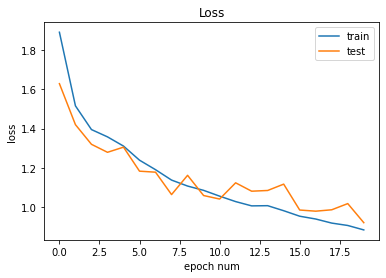

In [137]:
plot_results(list_to_plot={'train': model.loss_list, 
                           'test': model.test_loss_list}, 
             title='Loss', 
             xlab='epoch num', 
             ylab='loss')

#### F1-score

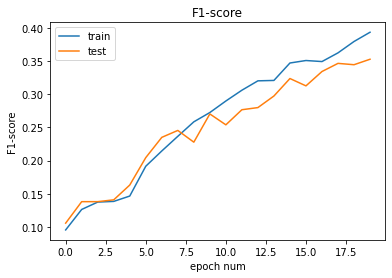

In [141]:
plot_results(list_to_plot={'train': model.f1_list, 
                           'test': model.test_f1_list}, 
             title='F1-score', 
             xlab='epoch num', 
             ylab='F1-score')

#### Accuracy

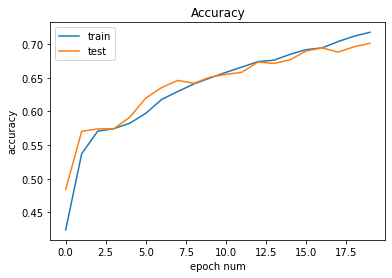

In [142]:
plot_results(list_to_plot={'train': model.acc_list, 
                           'test': model.test_acc_list}, 
             title='Accuracy', 
             xlab='epoch num', 
             ylab='accuracy')

#### Auxiliary cell, for the comparison of predicted classes and real ones

In [123]:
DISPLAY_EACH_PAIR_FLAG = False

y_pred = model.predict(x_test, batch_size)
preds = list(np.array(y_pred))
reals = y_test
true = 0

for i in range(len(reals)):
    if DISPLAY_EACH_PAIR_FLAG:
        print(f'Pread: {preds[i]} Real: {reals[i]}')
    true = true + 1 if preds[i] == reals[i] else true

print(f'True: {true}\nFalse: {len(reals)-true}')

True: 1334
False: 568


#### Confusion matrix

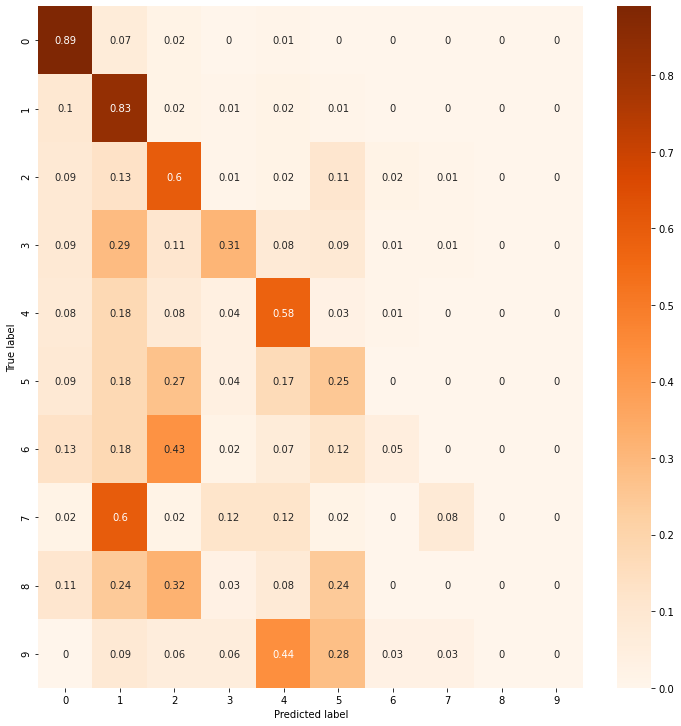

In [124]:
classes = list(range(10))

y_pred = model.predict(x_test, batch_size)

con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                          index = classes, 
                          columns = classes)

figure = plt.figure(figsize=(10, 10))
sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.Oranges)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### Podsumowanie
Do zaimplementowanego w ramach poprzedniego ćwiczenia modelu sieci rekurencyjnej dodano następujące funkcjonalności:
- Opcję wykorzystania 3 różnych publicznie dostępnych, pretrenowanych modeli wektorowej reprezentacji tekstów, zastępujących bądź wczytywanych do warstwy word embedding. Wybrano:
    - 'word2vec-google-news-300'
    - 'glove-wiki-gigaword-100'
    - 'glove-twitter-100'
- Dwukierunkowość w warstwie LSTM, która przetwarza sekwencje w kolejności standardowej oraz odwróconej i konkatenuje otrzymane wyniki.


Następnie zbadano wpływ następujących parametrów modelu, na efekty uczenia:
- Wykorzystanie pretrenowanych modeli wektorowej reprezentacji tekstów:
    - badano wymienione wyżej modele zestawiając osiągnięcia z wynikami podejścia stosującego własną implementacje warstwy embedding
- Stosowanie dwukierunkowości w warstwie LSTM:
    - badano ustawienia: {True, False}
- Model sieci rekurancynej:
    - dwa zadane: {RNN, LSTM}


Testy wykonywano na wspólnych ustawieniach parametrów, korzystając ze wniosków wyciągniętych przy okazji poprzedniego ćwiczenia:
- metoda optymalizacji = Adam
- wartość współczynnika uczenia = 0.001
- wielkość paczek = 100
- maksymalna długość wypełnienia wektorów = 64
- wielkości warstw = 10
- wymiar embeddingu własnej warstwy = 500
- n najczęstszych słów = 2000


Najleprze wyniki dla pretrenowanych modeli wektorowej reprezentacji tekstów (F1 = 0.3530) otrzymano dla usatwień:
- model: LSTM
- pretrenowany model wektorowej reprezentacji tekstów: glove-twitter-100
- stosowanie dwukierunkowości w warstwie LSTM: True


Po dokonaniu ewaluacji znalezionej najlepszej konfiguracji hiperparametrów na zbiorze testowym, przedstawiono wizualizacje otrzymanych rezultatów:
- zestawienie wartości metryki F1 w zależności od epoki (dla zbioru treningowego i testowego)
- zestawienie wartości metryki accuracy w zależności od epoki (dla zbioru treningowego i testowego)
- wykresy krzywej funkcji kosztu w zależności od epoki (dla zbioru treningowego i testowego)
- macierz pomyłek


### Wnioski
- Stosowanie zaimplementowanej architektury sieci LSTM daje zwykle znacznie lepsze rezultaty w odniesieniu do RNN
- Wykorzystanie dwukierunkowości w warstwie LSTM w każdym przypadku przełożyło się na polepszenie wyników
- Z wybranych pretrenowanych modeli wektorowej reprezentacji tekstów: 'word2vec-google-news-300' oraz 'glove-twitter-100' okazały się lepsze w przypadku wykonanych eksperymentów od 'glove-wiki-gigaword-100'
- Natomiast stosowanie własnej warstwy embedding w miejsce korzystania z wybranych modeli wektorowej reprezentacji tekstów przedkłada się na lepsze rezultaty klasyfikacji
- Zwiększenie epok uczenia polepsza wyniki (wpływa oczywiście także na czasy szkoleń)